In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import optimizers
from keras import backend as K
from keras.callbacks import Callback, TensorBoard, ModelCheckpoint, LearningRateScheduler

Using TensorFlow backend.


In [3]:
from Models.PoolingAndFire import *
from PreProcess import *

In [4]:
print(K.tensorflow_backend._get_available_gpus())

[]


In [5]:
LOG_DIR = os.path.expanduser("~/logs/SqueezeDet/")
#DATA_DIR = os.path.expanduser("~/datasets/Generated")
DATA_DIR = os.path.expanduser("~/datasets/RHD/RHD_published_v2/training/color")
TRAIN_DIR = os.path.expanduser("~/datasets/RHD/processed/train")
VALIDATION_DIR = os.path.expanduser("~/datasets/RHD/processed/validation")
ANNOTATIONS_PATH = os.path.expanduser("~/datasets/RHD/processed/train/annotations")
RHD_ANNOTATIONS_FILE = os.path.expanduser("~/datasets/RHD/RHD_published_v2/training/anno_training.pickle")
#MODEL_SAVE_FILE = "./results/model_checkpoint.h5py"

In [6]:
BATCHSIZE = 4
EPSILON = 1e-16

WEIGHT_DECAY = 0 # 0.001
KEEP_PROB = 0.5
CLASSES = 1

LABEL_WEIGHT = 1.0
OFFSET_LOSS_WEIGHT = 1.0
OFFSET_WEIGHT = 40.0

HEIGHT = 320
WIDTH = 320
CHANNELS = 3

INITIAL_LR = 1e-4
OPT_DECAY = 1e-5
DECAY_EPOCHES = 2.0
DECAY_DROP = 0.8

NUM_CLASSES = 42

LIMIT_SAMPLES = 100

VALIDATION_SPLIT = 0.1

In [7]:
if LIMIT_SAMPLES is None:
    num_samples = get_num_samples(DATA_DIR, type_sample='png')
else:
    num_samples = LIMIT_SAMPLES

In [8]:
num_train_samples = int((1-VALIDATION_SPLIT) * num_samples)
num_validation_samples = int(VALIDATION_SPLIT * num_samples)

all_samples = sorted(get_all_samples(DATA_DIR, sample_type='png'))
train_samples = all_samples[:num_train_samples]
validation_samples = all_samples[-num_validation_samples:]

train_validation_split(DATA_DIR, TRAIN_DIR, VALIDATION_DIR, train_samples, validation_samples, sample_type='png')

create_rhd_annotations(RHD_ANNOTATIONS_FILE,
                       ANNOTATIONS_PATH,
                       TRAIN_DIR,
                       fingers='ALL',
                       hands_to_annotate='BOTH',
                       annotate_non_visible=False)

  0%|          | 0/41258 [00:00<?, ?it/s]

Doing train/validation split. 90 training samples, 10 validation samples.


100%|██████████| 41258/41258 [00:00<00:00, 427151.81it/s]


100%|██████████| 91/91 [00:00<00:00, 3253.34it/s]

Creating annotations in directory: /home/clh/datasets/RHD/processed/train
Using annotation file: /home/clh/datasets/RHD/RHD_published_v2/training/anno_training.pickle
And outputting to: /home/clh/datasets/RHD/processed/train/annotations



In [9]:
model = create_model_multiple_detection(WIDTH, HEIGHT, CHANNELS, NUM_CLASSES)
out_shape = model.output_shape
anchor_width = out_shape[1]
anchor_height = out_shape[2]
print(f"Needed anchor shape: {anchor_width}x{anchor_height}")

Needed anchor shape: 20x20


In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 320, 320, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 160, 160, 128 3456        input[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 80, 80, 128)  0           conv1[0][0]                      
__________________________________________________________________________________________________
fire1_1/squeeze1x1 (Conv2D)     (None, 80, 80, 32)   4096        pool1[0][0]                      
__________________________________________________________________________________________________
fire1_1/bn

In [11]:
l = create_loss_function_multiple_detection(anchor_width,
                                            anchor_height,
                                            LABEL_WEIGHT,
                                            OFFSET_WEIGHT,
                                            OFFSET_LOSS_WEIGHT,
                                            NUM_CLASSES,
                                            EPSILON,
                                            BATCHSIZE)

In [12]:
print(f"Number of training samples: {num_train_samples}")
steps_epoch = num_train_samples // BATCHSIZE
if steps_epoch < 1:
    steps_epoch = 1
print(f"Steps per epoch: {steps_epoch}")

Number of training samples: 90
Steps per epoch: 22


In [13]:
opt = optimizers.Adam(lr=INITIAL_LR, decay=OPT_DECAY)
model.compile(loss=l, optimizer=opt)

In [14]:
data_gen = data_generator(TRAIN_DIR,
                          ANNOTATIONS_PATH,
                          BATCHSIZE,
                          WIDTH, HEIGHT,
                          anchor_width,
                          anchor_height,
                          num_classes=NUM_CLASSES,
                          sample_type='png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1.0
Number of points: 1
1.0
Number of points: 1
1.0
Number of points: 1
1.0
Number of points: 1
1.0
Number of points: 1
1.0
Number of points: 1
1.0
Number of points: 1
1.0
Number of points: 1
1.0
Number of points: 1
1.0
Number of points: 1
1.0
Number of points: 1
1.0
Number of points: 1
1.0
Number of points: 1
1.0
Number of points: 1
1.0
Number of points: 1
1.0
Number of points: 1
1.0
Number of points: 1
1.0
Number of points: 1
1.0
Number of points: 1
1.0
Number of points: 1
1.0
Number of points: 1
1.0
Number of points: 0
1.0
Number of points: 0
1.0
Number of points: 0
1.0
Number of points: 0
1.0
Number of points: 0
1.0
Number of points: 0
1.0
Number of points: 0
1.0
Number of points: 0
1.0
Number of points: 0
1.0
Number of points: 0
1.0
Number of points: 0
1.0
Number of points: 0
1.0
Number of points: 0
1.0
Number of points: 0
1.0
Number of points: 0
1.0
Number of points: 0
1.0
Number of points: 0
1.0
Number of points: 0
1.0
Number of points: 0
1.0
Number of points: 0
1.0
Number of po

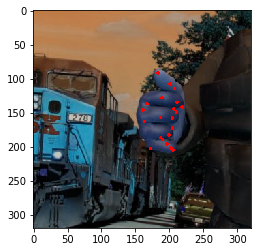

(4, 20, 20, 126)
(20, 20, 126)
1.0


In [20]:
images, labels = next(data_gen)


for c in range(len(images)):
    for i in range(NUM_CLASSES):
        l = np.zeros((20, 20, 3))

        l[:, :, 0] = labels[c][:, :, i]
        l[:, :, 1:] = labels[c][:, :, NUM_CLASSES+i:NUM_CLASSES+i+1]

        anchors = get_anchors(320, 320, 20, 20)
        max_val = 1.0 # np.max(l[:,:,0])
        print(max_val)
        pred_point = get_all_points_from_prediction(l,
                                                    anchors,
                                                    threshold=max_val,
                                                    do_scale=False,
                                                    offset_weight=OFFSET_WEIGHT)
        
        print(f"Number of points: {len(pred_point)}")
        for p in pred_point:
            x = p[0] + p[2]
            y = p[1] + p[3]

            #print(f"Predicted point: ({x}, {y})")

            cv2.circle(images[c], (int(x), int(y)), 1, (255, 0, 0), thickness=2)
    
    break



print(images.shape)
plt.imshow(images[0].reshape(320, 320, 3))
plt.show()

print(labels.shape)
print(labels[0].shape)
print(np.max(labels[0][:, :, 2]))

In [16]:
class PrintInfo(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        decay = self.model.optimizer.decay
        iterations = self.model.optimizer.iterations
        lr_with_decay = lr / (1. + decay * K.cast(iterations, K.dtype(decay)))
        print(f"Learning rate with decay: {K.eval(lr_with_decay)}")
        #print(f"lr={K.eval(lr)}, decay={K.eval(decay)}")
        print("")

print_info = PrintInfo()

#with tf.device('/cpu:0'):
#    model.fit_generator(data_gen,
#                        steps_per_epoch=steps_epoch,
#                        epochs=1000,
#                        verbose=1,
#                        callbacks=[print_info])